Spring 2021
<img src="https://www.cuipcairo.org/sites/default/files/styles/medium/public/49658177_2020840098011471_2893445443553853440_n.png?itok=672tzxcF"
 width="80px" align="right">

CIE 555, Neural Networks and Deep Learning

University of Science and Technology, Zewail City

<br>

<h1 align="center">Lab 10</h1>
<h1 align="center">Part II: Generative Adversarial Networks</h1>

---

# Task



![alt text](https://mgubaidullin.github.io/deeplearning4j-docs/img/GANs.png)

# Imports

In [ ]:
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy import vstack
from numpy.random import rand
from numpy.random import randint
from numpy.random import randn
import matplotlib.image as mpimg 

from keras.models import load_model
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

# Dataset

We will use the [MNIST Fashion dataset](https://keras.io/api/datasets/fashion_mnist/), which contains 60,000 training images and 10,000 testing images.


In [ ]:
from keras.datasets import fashion_mnist

(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


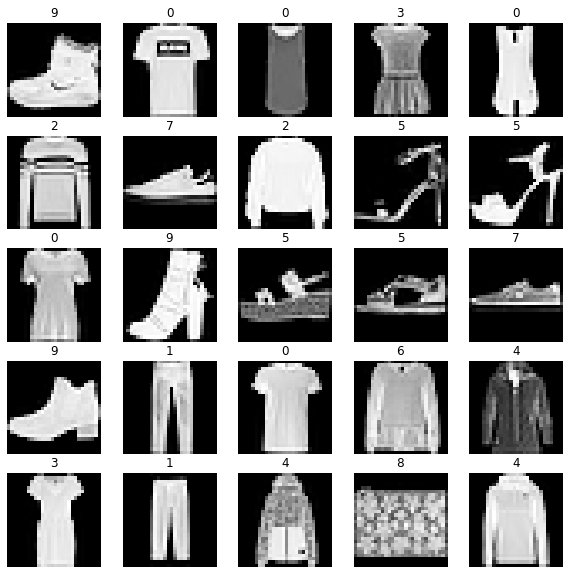

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(trainX[i], cmap='Greys_r')
    plt.title(trainy[i])
    plt.axis('off')
    
plt.show()

# Discriminator Model

## Build Discriminator Model

In [ ]:
# Define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):

      model = Sequential()
      model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(0.4))
      model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(0.4))
      model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(0.4))
      model.add(Flatten())
      model.add(Dense(1, activation='sigmoid'))

      # Compile model
      opt = Adam(learning_rate=0.0002, beta_1=0.5)
      model.compile(loss = 'binary_crossentropy',
                    optimizer = opt,
                    metrics = ['accuracy'])

      return model

In [ ]:
# Define model
model = define_discriminator()
# Summarize model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)         

## Train Discriminator Model

Load and prepare MNIST training images.


In [ ]:
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = fashion_mnist.load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

Define a function to select a random subsample of images; it will also return class labels for the sample, specifically a class label of 1, to indicate real images.

In [ ]:
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [ ]:
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

>1 real=49% fake=36%
>2 real=64% fake=45%
>3 real=65% fake=48%
>4 real=72% fake=55%
>5 real=68% fake=73%
>6 real=69% fake=69%
>7 real=73% fake=73%
>8 real=65% fake=87%
>9 real=70% fake=90%
>10 real=65% fake=91%
>11 real=71% fake=96%
>12 real=65% fake=94%
>13 real=70% fake=89%
>14 real=73% fake=98%
>15 real=70% fake=98%
>16 real=70% fake=98%
>17 real=73% fake=100%
>18 real=74% fake=98%
>19 real=72% fake=98%
>20 real=76% fake=100%
>21 real=77% fake=99%
>22 real=71% fake=100%
>23 real=74% fake=99%
>24 real=79% fake=100%
>25 real=84% fake=100%
>26 real=80% fake=99%
>27 real=88% fake=100%
>28 real=82% fake=100%
>29 real=85% fake=100%
>30 real=91% fake=100%
>31 real=89% fake=100%
>32 real=94% fake=100%
>33 real=86% fake=99%
>34 real=90% fake=100%
>35 real=92% fake=100%
>36 real=93% fake=100%
>37 real=93% fake=100%
>38 real=93% fake=100%
>39 real=94% fake=100%
>40 real=95% fake=98%
>41 real=90% fake=100%
>42 real=95% fake=100%
>43 real=98% fake=98%
>44 real=95% fake=99%
>45 real=91% fake=100%

# Generator Model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
    # reshape into something image-like to pass into a convolutional layer
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
    # output layer must have 1 filter - why?
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

In [ ]:
# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 28, 28, 128)      

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

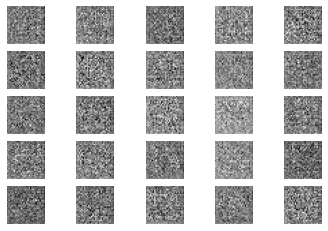

In [ ]:
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()

# Training

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 75521     
Total params: 1,239,810
Trainable params: 1,164,289
Non-trainable params: 75,521
_________________________________________________________________


In [ ]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='Greys_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>79, 155/234, d=0.694, g=0.717
>79, 156/234, d=0.685, g=0.688
>79, 157/234, d=0.693, g=0.665
>79, 158/234, d=0.699, g=0.664
>79, 159/234, d=0.690, g=0.664
>79, 160/234, d=0.679, g=0.668
>79, 161/234, d=0.692, g=0.674
>79, 162/234, d=0.693, g=0.688
>79, 163/234, d=0.700, g=0.727
>79, 164/234, d=0.696, g=0.737
>79, 165/234, d=0.690, g=0.758
>79, 166/234, d=0.683, g=0.777
>79, 167/234, d=0.684, g=0.754
>79, 168/234, d=0.684, g=0.737
>79, 169/234, d=0.687, g=0.700
>79, 170/234, d=0.701, g=0.700
>79, 171/234, d=0.697, g=0.691
>79, 172/234, d=0.694, g=0.687
>79, 173/234, d=0.689, g=0.676
>79, 174/234, d=0.683, g=0.672
>79, 175/234, d=0.685, g=0.671
>79, 176/234, d=0.690, g=0.684
>79, 177/234, d=0.693, g=0.686
>79, 178/234, d=0.690, g=0.702
>79, 179/234, d=0.695, g=0.742
>79, 180/234, d=0.695, g=0.759
>79, 181/234, d=0.684, g=0.748
>79, 182/234, d=0.686, g=0.737
>79, 183/234, d=0.691, g=0.714
>79, 184/234, d=0.683, g=0.705
>79, 185/234, d=0.6

# Evaluation

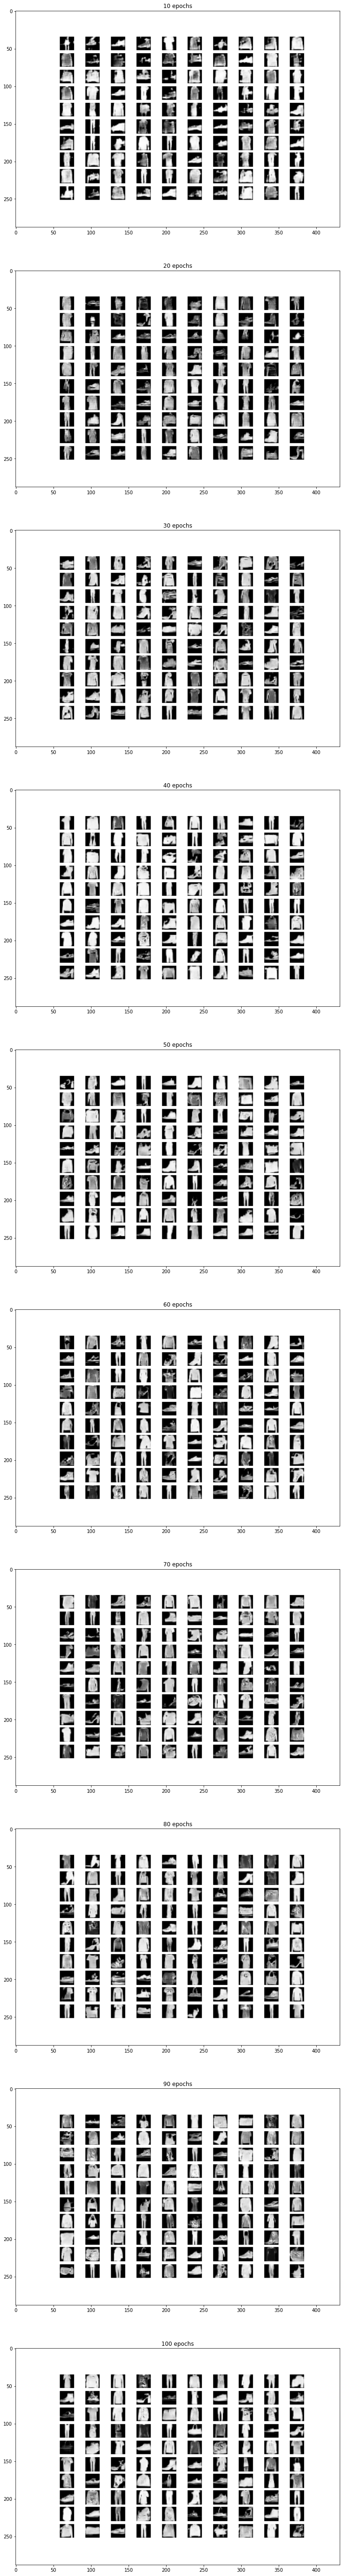

In [ ]:
fig=plt.figure(figsize=(100, 100))
columns = 1
rows = 10
for i in range(1, columns*rows +1):
    filename = 'generated_plot_e%03d.png' % (i * 10)
    img = mpimg.imread(filename)
    fig.add_subplot(rows, columns, i)
    plt.title("{} epochs".format(i*10))
    plt.imshow(img)
plt.show()


# New Image Generation

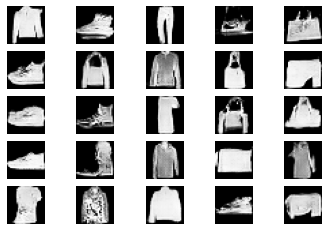

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='Greys_r')
	plt.show()

# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

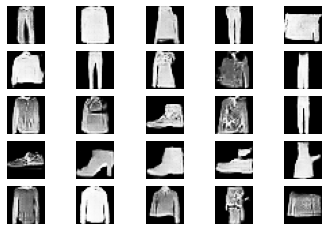

In [ ]:
# load model
model = load_model('generator_model_060.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

Both models gave acceptable results.